# Tree building A 

In this notebook I sequentially build the best tree for patient W. The process goes as follows:

1. Build a tree class with the data as attribute
2. Find the 2 most covered mutations and build all potential trees
3. Run SVI on each tree independently
4. Select any tree with lowest ELBO in the last 20 iterations
5. Add the next most covered mutation and generate all potential trees
6. Repeat 3-5 until trees contain all mutations
7. Select one of the best trees and compute clonal assignment probabilities for single-cells

## Import packages 



<br>



In [1]:
# Import packages
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import itertools
import os

import dill

import time
from datetime import datetime
from timeit import default_timer as timer
from datetime import timedelta

import scipy
from scipy.stats import betabinom

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam, AdagradRMSProp, MultiStepLR
from torch.distributions import constraints
from pyro.ops.indexing import Vindex
pyro.set_rng_seed(100)

# import helper functions and tree class form source code files (present in the same directory)
from helper_functions import *

In [2]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

## Load data

In [3]:
# load data from patient W
with open("data/AKLA.json") as f:
    data = json.load(f)
       
# add type of mutations: 0 = CNV, 1 = nuclear, 2 = mitochondrial
data["type"] = np.array([1, 1, 2])


In [4]:
data['colnames']

['DNMT3A', 'TP53', 'X2108.G.A']

# Build tree A

Here I heuristically build the clonal hierarchy of patient K

## Create tree class 


In [5]:
data_svi = {"M": torch.Tensor(data["M"]),
         "N": torch.Tensor(data["N"]),
         "mut_type": torch.Tensor([1,1,2]),
         "h_alpha": torch.Tensor([1000.0, 1000.0, 1]),
         "h_beta": torch.Tensor([1000.0,1000.0, 1]),
         "af_alpha": torch.Tensor([[45, 50, 1],[0,0,0]]),
         "af_beta": torch.Tensor([[100-45, 100-50, 1], [1,1,1]]),
         "r_cnv": torch.Tensor([0,0,0]),
         "names": data["colnames"],
         "barcodes": data["cell_barcode"], 
         "umapx": data["umapx"], 
         "umapy": data["umapy"],
         "class_af": True, 
         "class_assign": torch.cuda.IntTensor(data["timepoint"]),
         "class_names": ["day0", "day15"],
         "cnv_celltype": False,                                         
         "celltype": [],
         "celltype_names": [],
         "cnv_ct_mean": [],
         "cnv_ct_sd": []}


In [6]:
t = tree("A", data_svi)

## Initial tree with DNMT3A & X2108.G.A

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 1m 1s
Model fit to tree 1 in 0m 58s
Model fit to tree 2 in 0m 59s
Model fit to tree 3 in 0m 58s
Trees [0, 1, 3] selected for mutations ['X2108.G.A', 'DNMT3A']
tensor([[0., 0.],
        [1., 0.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 1.],
        [1., 1.]])
tensor([[0., 0.],
        [1., 1.]])
Total run time 0h 3m 57s


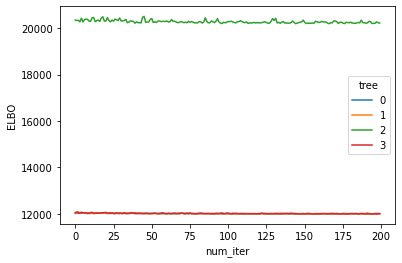

In [7]:
# add mutation and select the best tree(s)
t.sel_mutation(initial = True)
t.select_tree(num_iter = 300, init = 100)

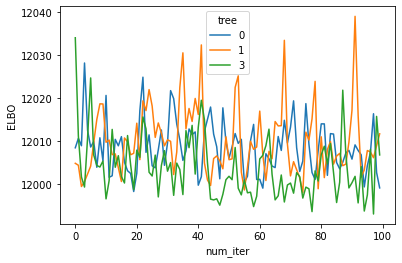

In [14]:
t.print_elbo(300, 200, include = [0,1,3])

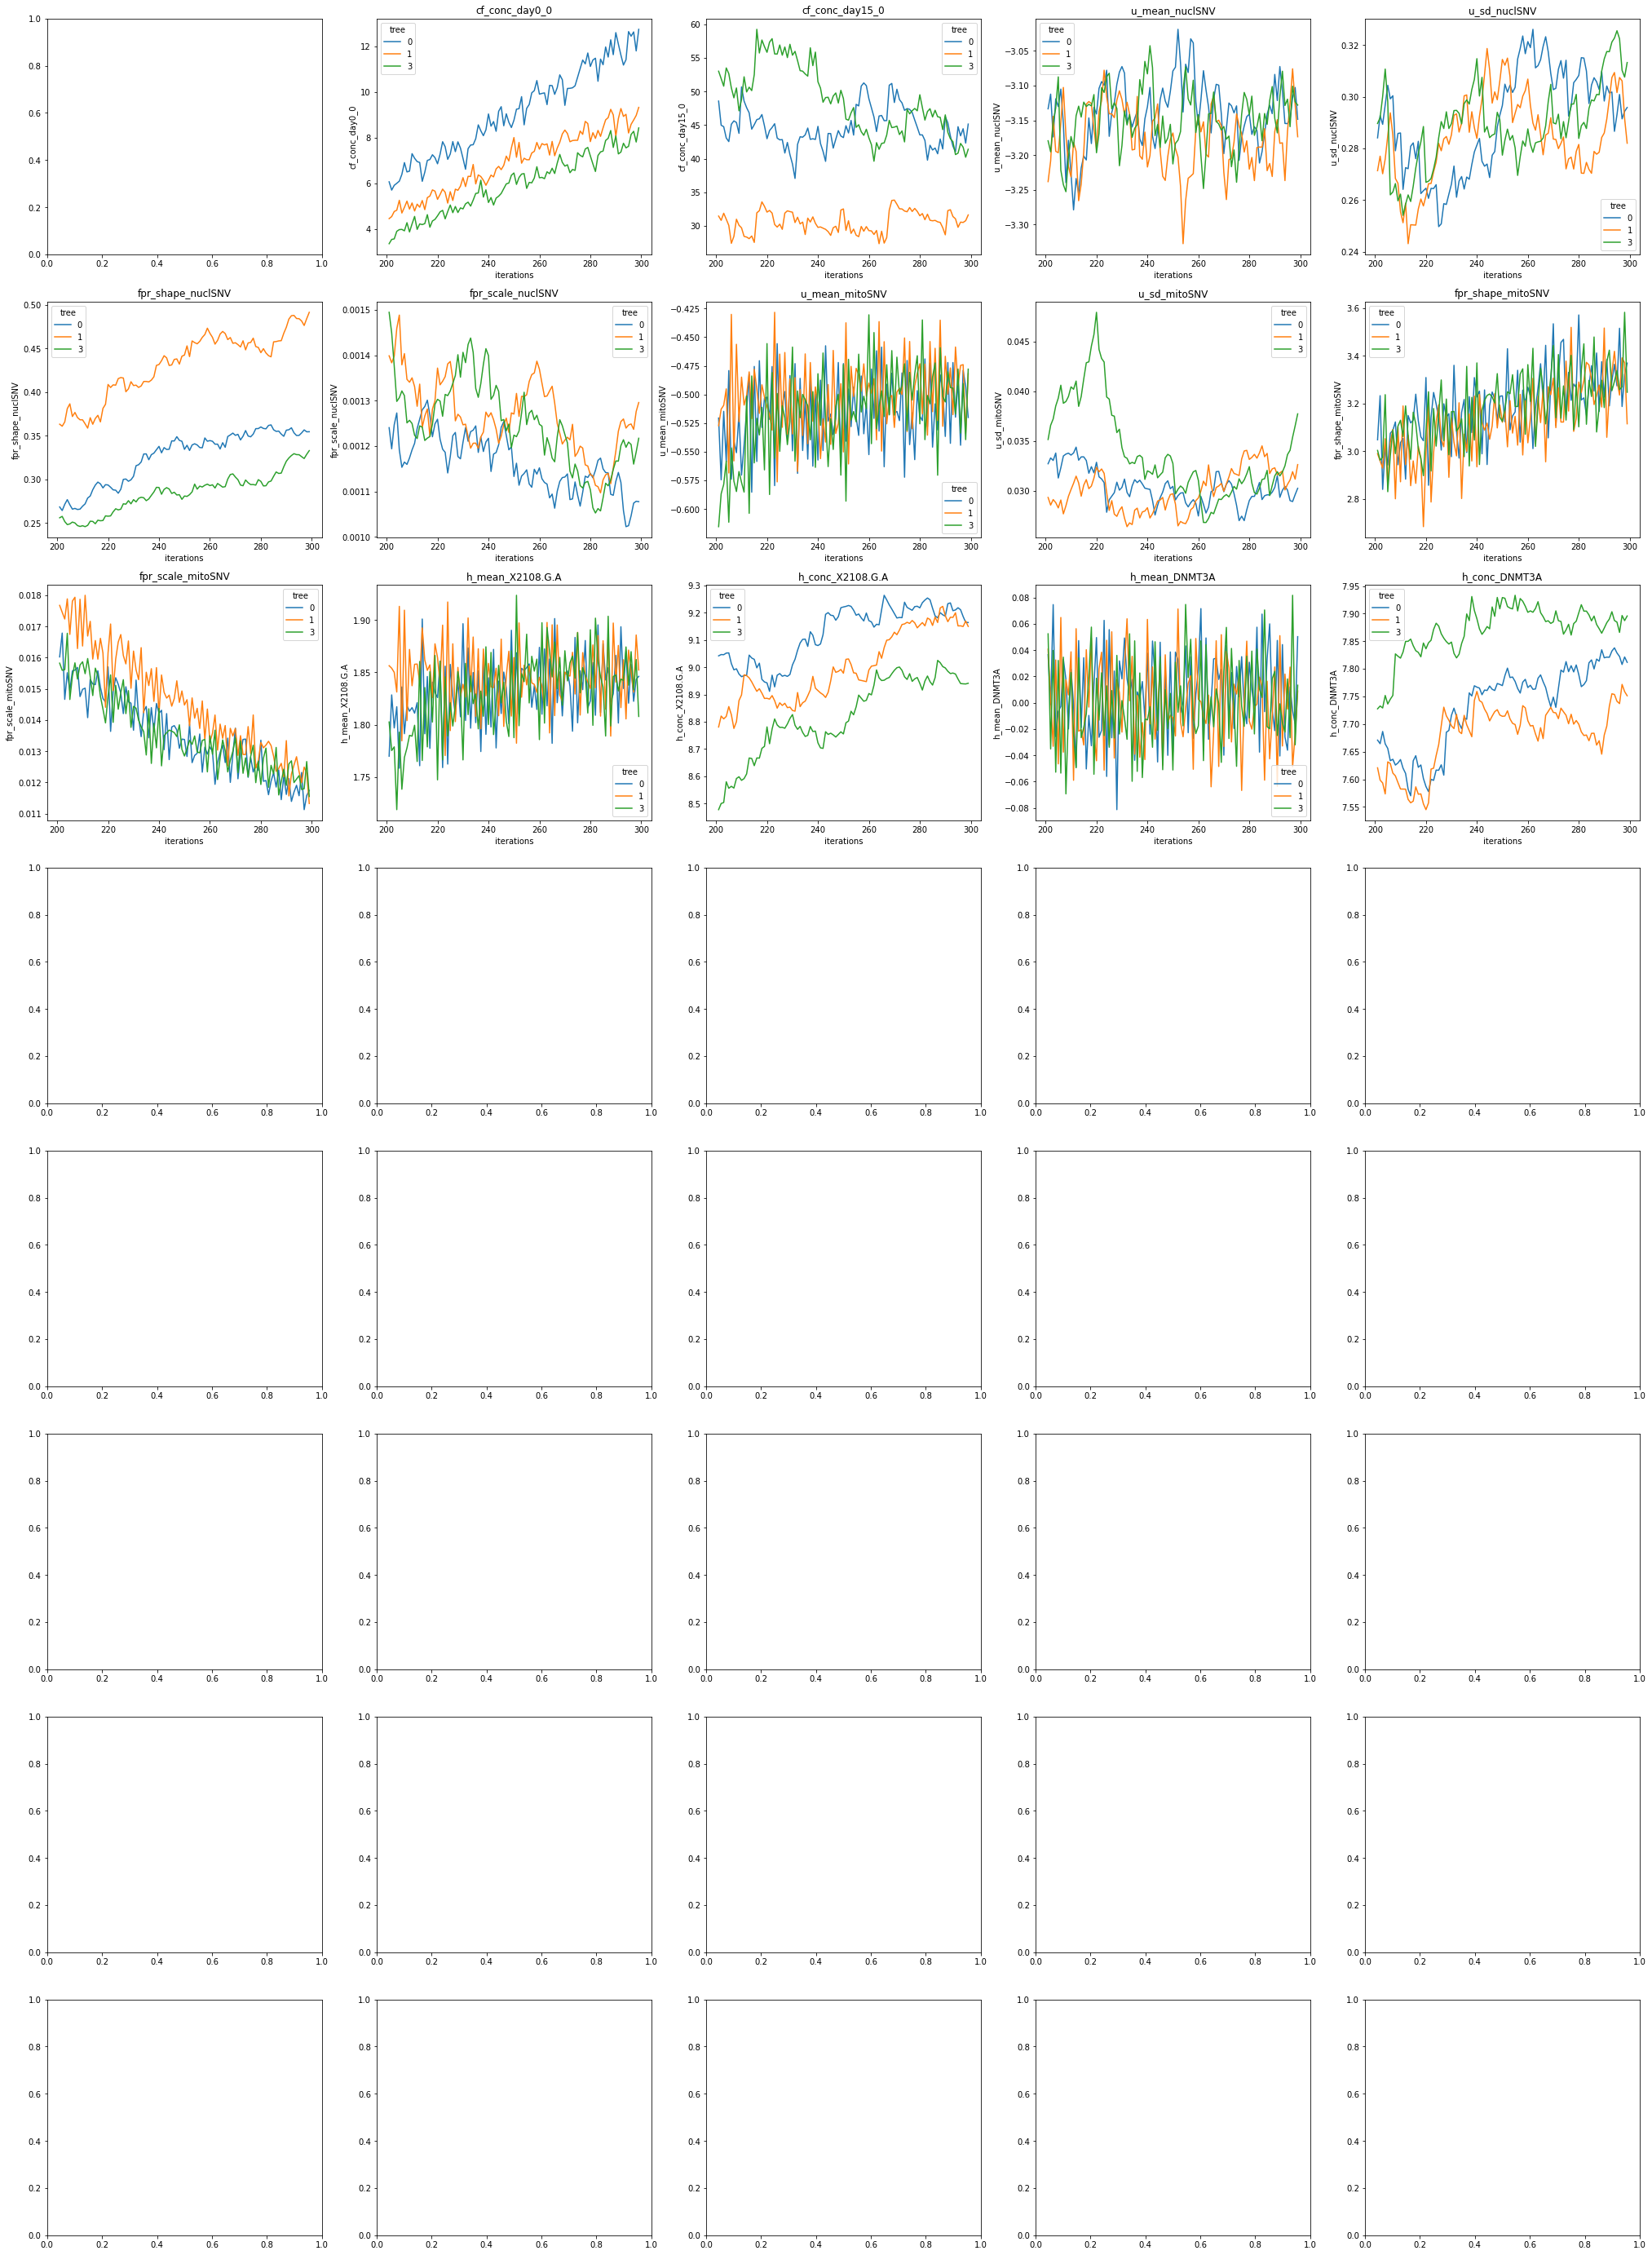

In [15]:
t.print_params(include = [0,1,3], it = 200)

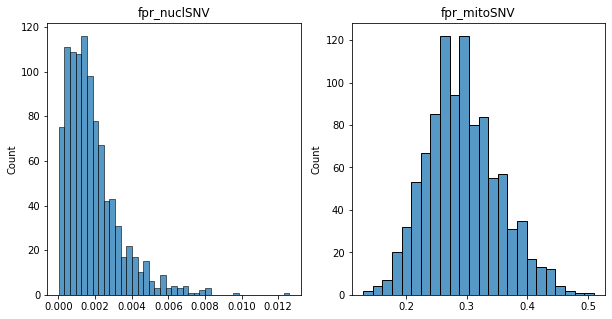

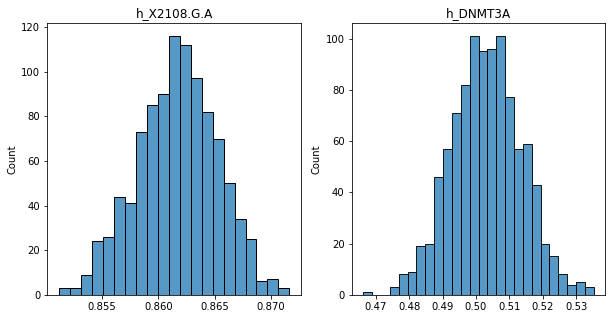

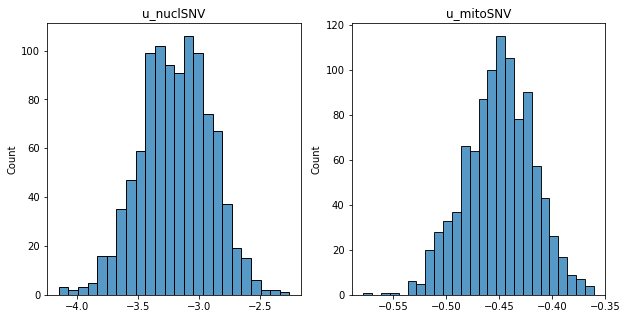

In [16]:
t.plot_posterior("all", 1, 1000)

## Add TP53

TP53 added to the tree
Choosing best tree among 18 potential candidates
Model fit to tree 0 in 1m 15s
Model fit to tree 1 in 1m 15s
Model fit to tree 2 in 1m 15s
Model fit to tree 3 in 1m 8s
Model fit to tree 4 in 1m 16s
Model fit to tree 5 in 1m 15s
Model fit to tree 6 in 1m 12s
Model fit to tree 7 in 1m 7s
Model fit to tree 8 in 1m 17s
Model fit to tree 9 in 1m 1s
Model fit to tree 10 in 1m 17s
Model fit to tree 11 in 1m 18s
Model fit to tree 12 in 1m 16s
Model fit to tree 13 in 1m 6s
Model fit to tree 14 in 1m 12s
Model fit to tree 15 in 1m 15s
Model fit to tree 16 in 1m 17s
Model fit to tree 17 in 1m 14s
Trees [1, 2, 5, 8, 9, 12, 15, 16, 17] selected for mutations ['X2108.G.A', 'DNMT3A', 'TP53']
tensor([[0., 0., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
  

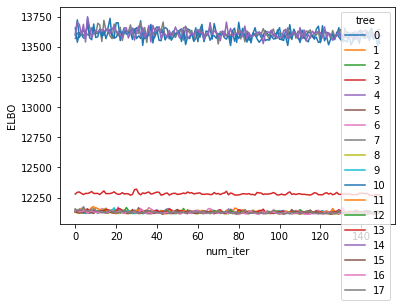

In [17]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 300, init = 150)

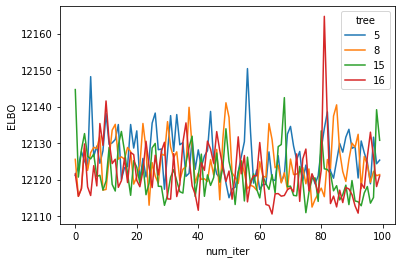

In [18]:
t.print_elbo(300, 200, include = [16,8,5, 15])

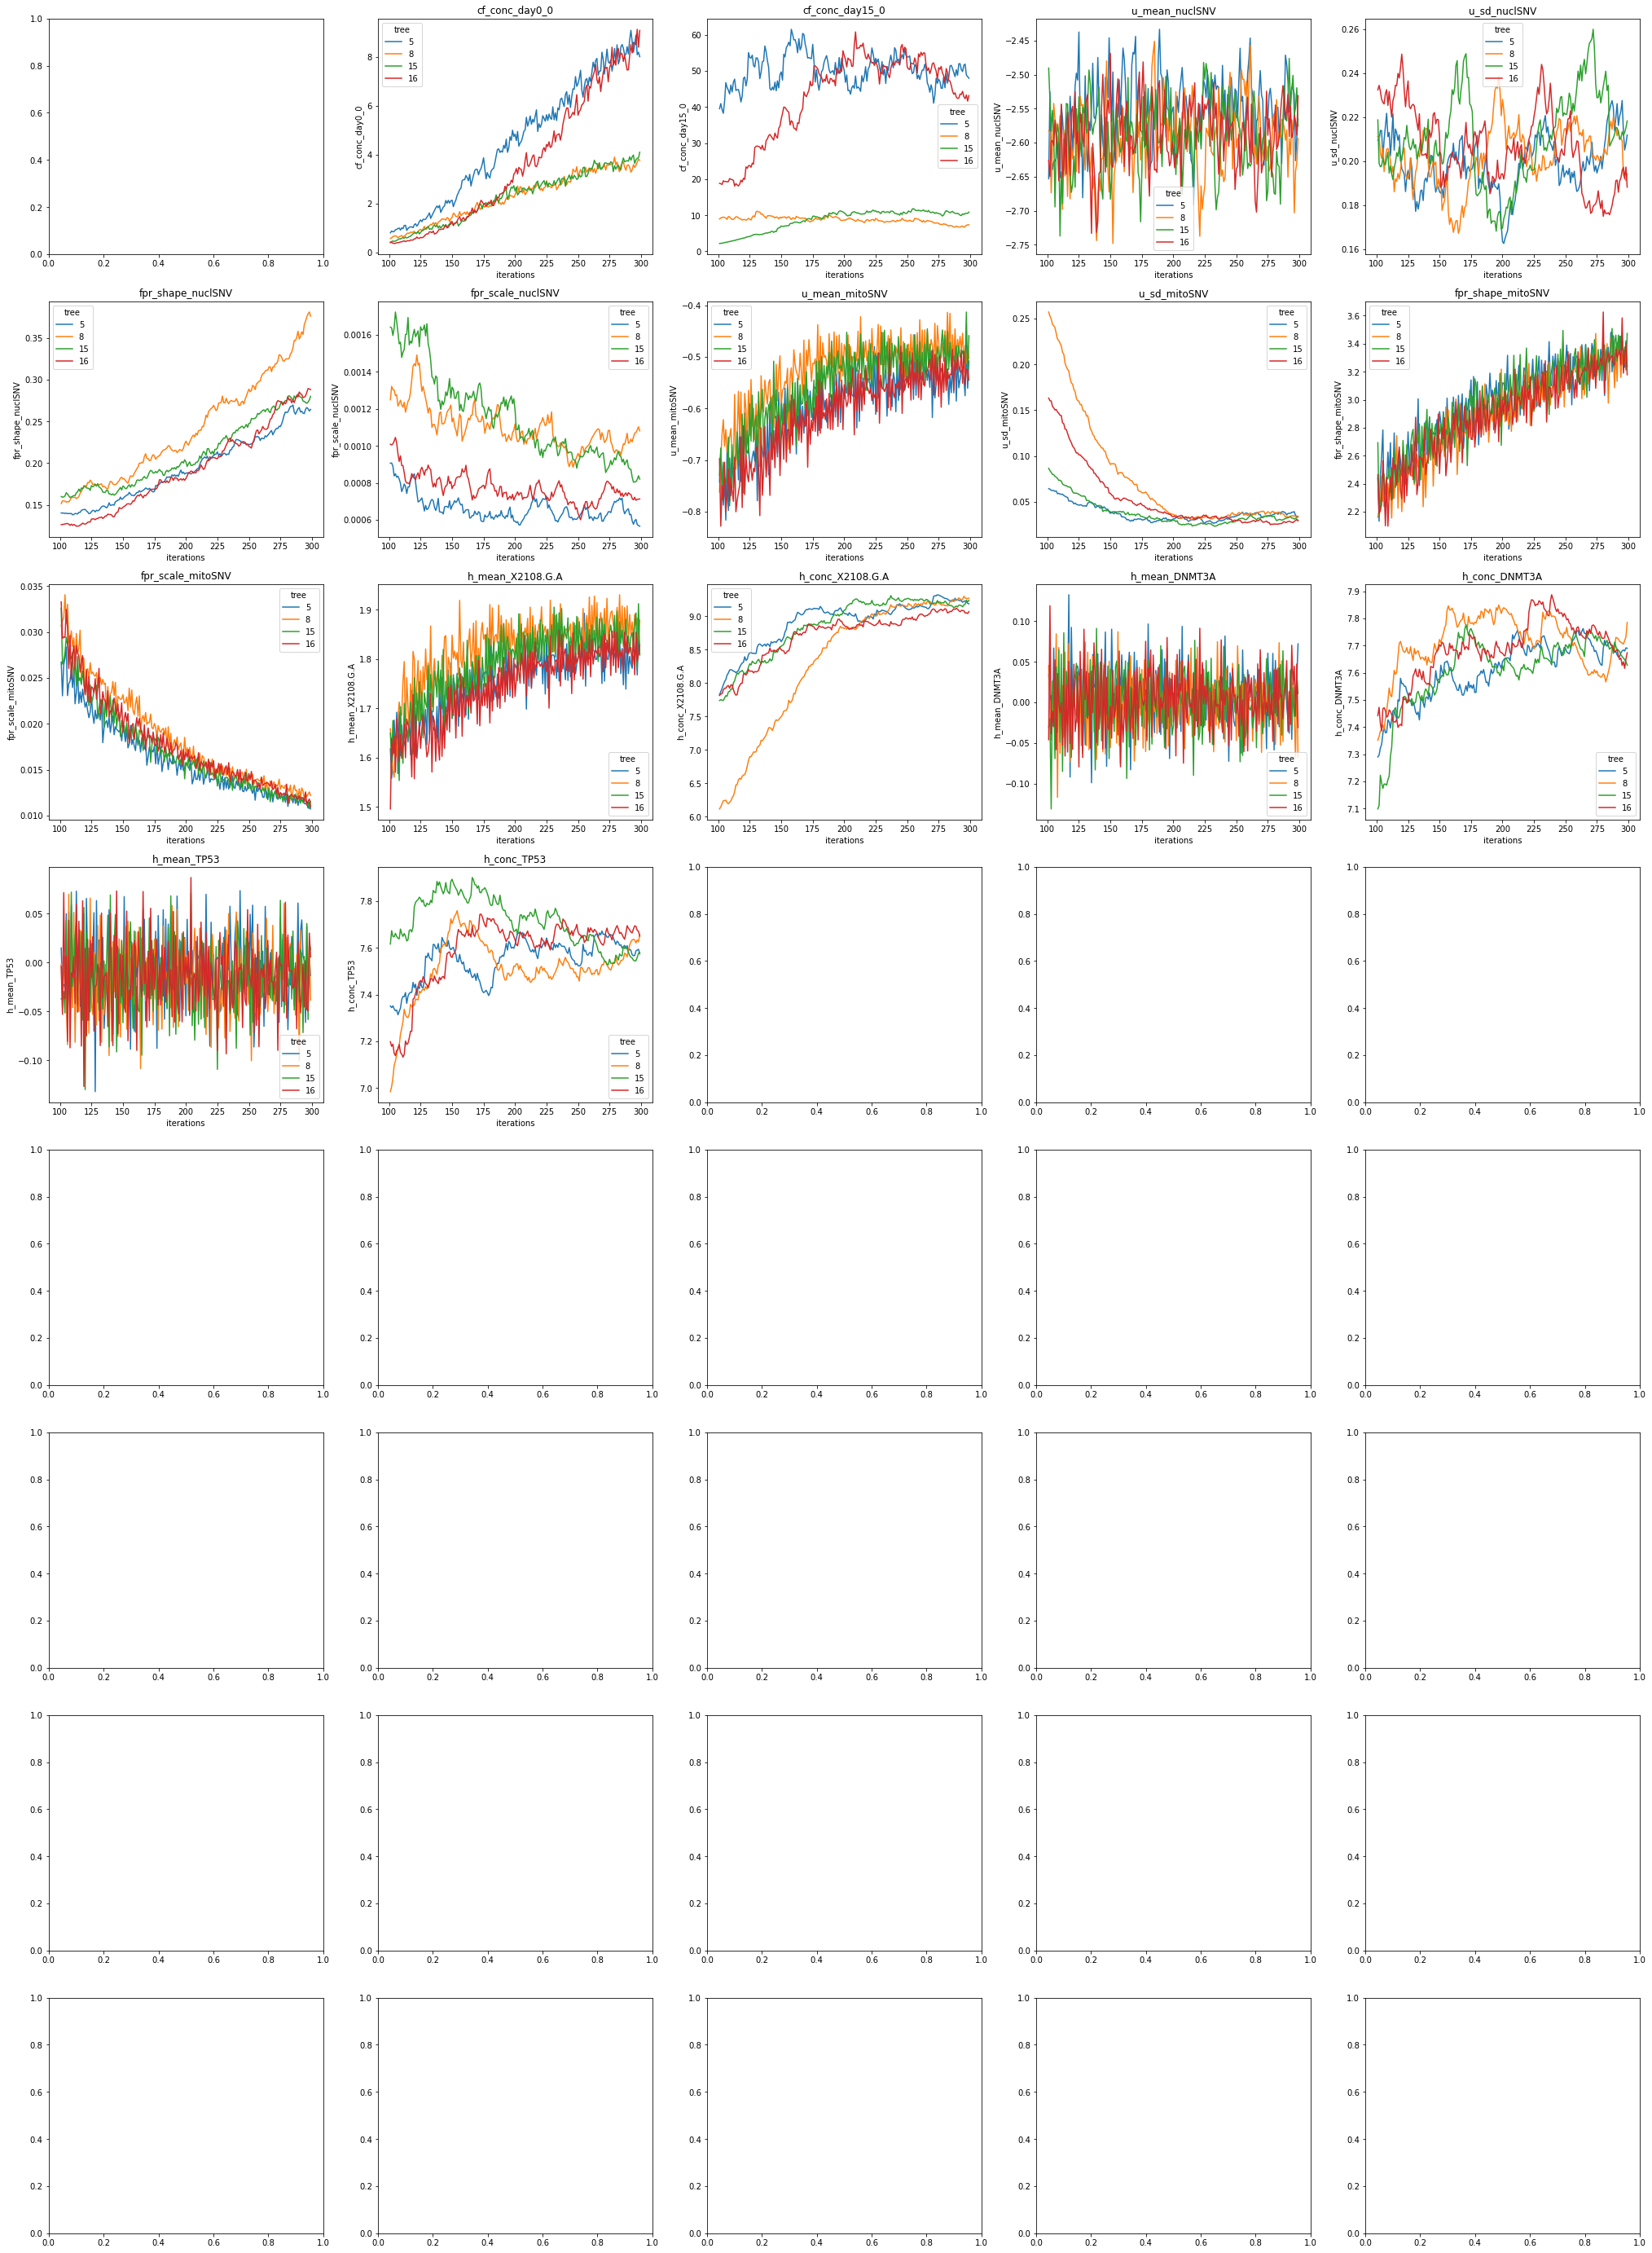

In [20]:
t.print_params(include = [16,8,5, 15], it = 100)

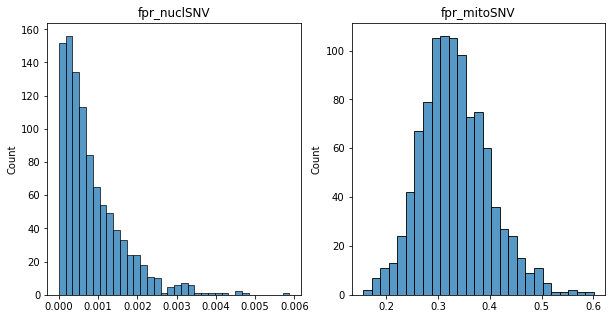

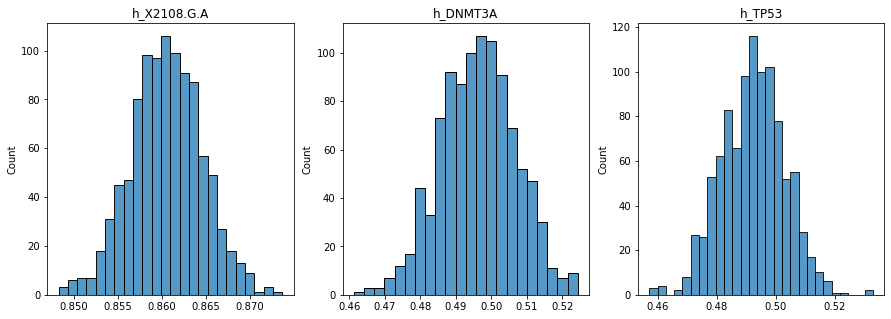

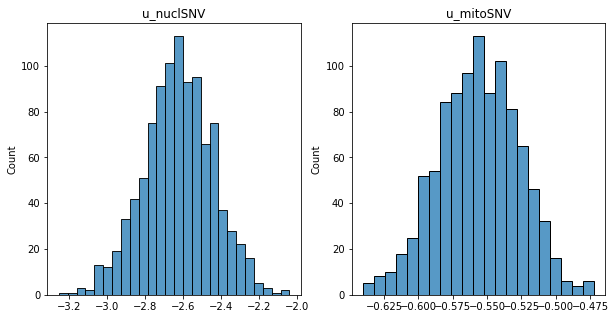

In [21]:
t.plot_posterior("all", 16, 1000)

# Infer clonal assignment probabilities

In [22]:
# Compute clonal assignment probabilities for all selected trees
for i in range(len(t.tree_indices)):
    t.clonal_assignment(tree = i)

Computing clonal assignment probabilities for tree 0
Clonal assignment probabilities computed in 1m and 16s
Computing clonal assignment probabilities for tree 1
Clonal assignment probabilities computed in 1m and 1s
Computing clonal assignment probabilities for tree 2
Clonal assignment probabilities computed in 1m and 18s
Computing clonal assignment probabilities for tree 3
Clonal assignment probabilities computed in 1m and 20s
Computing clonal assignment probabilities for tree 4
Clonal assignment probabilities computed in 1m and 6s
Computing clonal assignment probabilities for tree 5
Clonal assignment probabilities computed in 1m and 20s
Computing clonal assignment probabilities for tree 6
Clonal assignment probabilities computed in 1m and 19s
Computing clonal assignment probabilities for tree 7
Clonal assignment probabilities computed in 1m and 20s
Computing clonal assignment probabilities for tree 8
Clonal assignment probabilities computed in 1m and 21s


# Get posterior predictive 

In [26]:
# Get posterior predictive for tree with all mutations merge in one clone
t.get_post_predictive(tree = 16, num_samples = t.M.shape[0])

# Save objects

In [28]:
# export object as pickle
t.export_pickle("svi_objects/AKLA.pickle")

Tree object saved as pickle!


In [27]:
# save tree object
with open("svi_objects/tree_"+t.name +".pickle", "wb") as f:
    pickle.dump(t, f, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
t.M.shape[0]

5064